In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 128 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


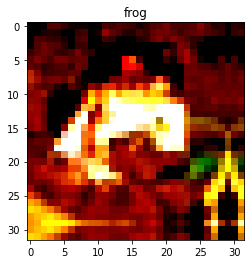

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine_batch128_lr03.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.3
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Read model from checkpoint
Restart from epoch 100
Epoch 101, Train loss 0.008833722135990627, Test loss 0.4015650915194161, Train accuracy 99.70428388746804, Test accuracy 92.94897151898734, Cost 93.4078643321991 s
Epoch 102, Train loss 0.012415786264380148, Test loss 0.3890541390150408, Train accuracy 99.58240089514067, Test accuracy 92.63251582278481, Cost 112.27361416816711 s
Epoch 103, Train loss 0.008948614760601978, Test loss 0.40313538673180566, Train accuracy 99.67231457800511, Test accuracy 92.67207278481013, Cost 114.1089198589325 s
Epoch 104, Train loss 0.008932210554488932, Test loss 0.39215024013685273, Train accuracy 99.71027813299233, Test accuracy 93.05775316455696, Cost 115.41217350959778 s
Epoch 105, Train loss 0.009628094123879103, Test loss 0.38677739082022183, Train accuracy 99.68510230179028, Test accuracy 93.17642405063292, Cost 117.83432030677795 s
Model saved in epoch 105
Epoch 106, Train loss 0.008003368816805778, Test loss 0.41392843444136124, Train accuracy 

Epoch 149, Train loss 0.002717934460230268, Test loss 0.4359483440654187, Train accuracy 99.91408248081841, Test accuracy 93.56210443037975, Cost 112.67450428009033 s
Epoch 150, Train loss 0.0026555061522568254, Test loss 0.4347631144749967, Train accuracy 99.92407289002557, Test accuracy 93.3445411392405, Cost 110.85817360877991 s
Model saved in epoch 150
Epoch 151, Train loss 0.0013470323668586047, Test loss 0.44659565606071977, Train accuracy 99.96803069053709, Test accuracy 93.33465189873418, Cost 109.38111329078674 s
Epoch 152, Train loss 0.0012577442936916345, Test loss 0.4518754645427571, Train accuracy 99.96403452685422, Test accuracy 93.5126582278481, Cost 112.37133026123047 s
Epoch 153, Train loss 0.0026702217282137328, Test loss 0.48684958679766593, Train accuracy 99.91208439897699, Test accuracy 93.33465189873418, Cost 113.05651044845581 s
Epoch 154, Train loss 0.0018780693064052363, Test loss 0.46139406205355366, Train accuracy 99.9320652173913, Test accuracy 93.2753164556

Epoch 197, Train loss 0.0009412375910412668, Test loss 0.4477184520020515, Train accuracy 99.96803069053709, Test accuracy 93.69066455696202, Cost 110.36637306213379 s
Epoch 198, Train loss 0.0011822750077400365, Test loss 0.44613754673849176, Train accuracy 99.95404411764706, Test accuracy 93.89833860759494, Cost 110.4617772102356 s
Epoch 199, Train loss 0.0007667781400647721, Test loss 0.44617903741854653, Train accuracy 99.98601342710998, Test accuracy 94.08623417721519, Cost 111.99135279655457 s
Epoch 200, Train loss 0.0009950620719386305, Test loss 0.4608669028251986, Train accuracy 99.96403452685422, Test accuracy 93.75, Cost 112.82478022575378 s
Model saved in epoch 200
Epoch 201, Train loss 0.001279813352500824, Test loss 0.4540663101250612, Train accuracy 99.96803069053709, Test accuracy 93.8192246835443, Cost 112.67062067985535 s
Epoch 202, Train loss 0.0012084704022856288, Test loss 0.4542712624880332, Train accuracy 99.97002877237851, Test accuracy 93.94778481012658, Cost 1

Epoch 245, Train loss 0.0004775786750145725, Test loss 0.4675548024758508, Train accuracy 99.98601342710998, Test accuracy 93.99723101265823, Cost 110.09497213363647 s
Model saved in epoch 245
Epoch 246, Train loss 0.0005094025775257248, Test loss 0.4725830344176745, Train accuracy 99.98601342710998, Test accuracy 94.01700949367088, Cost 112.62985372543335 s
Epoch 247, Train loss 0.00039567620719253973, Test loss 0.47351862320417093, Train accuracy 99.9880115089514, Test accuracy 94.02689873417721, Cost 111.58243036270142 s
Epoch 248, Train loss 0.0004489312518459541, Test loss 0.45721808863402924, Train accuracy 99.9880115089514, Test accuracy 93.86867088607595, Cost 109.91888165473938 s
Epoch 249, Train loss 0.0007102108522474918, Test loss 0.4791651328530493, Train accuracy 99.97002877237851, Test accuracy 93.9181170886076, Cost 87.2529776096344 s
Epoch 250, Train loss 0.00046481442230873385, Test loss 0.47591295291351365, Train accuracy 99.98601342710998, Test accuracy 93.967563291

Epoch 293, Train loss 0.0001694777604566292, Test loss 0.4910465659502941, Train accuracy 99.99400575447571, Test accuracy 93.94778481012658, Cost 78.9495997428894 s
Epoch 294, Train loss 0.00012413483401713408, Test loss 0.4893356967670254, Train accuracy 99.99800191815856, Test accuracy 94.04667721518987, Cost 79.05254077911377 s
Epoch 295, Train loss 0.00011043003963172283, Test loss 0.4824515326490885, Train accuracy 99.99800191815856, Test accuracy 94.0565664556962, Cost 79.15903830528259 s
Model saved in epoch 295
Epoch 296, Train loss 8.350990536075235e-05, Test loss 0.48204282732515397, Train accuracy 100.0, Test accuracy 94.09612341772151, Cost 79.32311534881592 s
Epoch 297, Train loss 7.980257431277048e-05, Test loss 0.4830171961007239, Train accuracy 100.0, Test accuracy 94.02689873417721, Cost 79.36272525787354 s
Epoch 298, Train loss 0.00015822118765516382, Test loss 0.48731838435500485, Train accuracy 99.99200767263427, Test accuracy 93.92800632911393, Cost 79.27983093261

Epoch 343, Train loss 6.455261123352476e-05, Test loss 0.4843666481349287, Train accuracy 99.99800191815856, Test accuracy 94.27412974683544, Cost 79.03758645057678 s
Epoch 344, Train loss 3.100642589377572e-05, Test loss 0.4838294788629194, Train accuracy 100.0, Test accuracy 94.25435126582279, Cost 79.12222647666931 s
Epoch 345, Train loss 3.130891785546213e-05, Test loss 0.4845856953931006, Train accuracy 100.0, Test accuracy 94.20490506329114, Cost 79.08648180961609 s
Model saved in epoch 345
Epoch 346, Train loss 4.6288689751580275e-05, Test loss 0.4853018079943295, Train accuracy 99.99800191815856, Test accuracy 94.2246835443038, Cost 79.0975832939148 s
Epoch 347, Train loss 5.4386470163563e-05, Test loss 0.48521902567789527, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 78.96668434143066 s
Epoch 348, Train loss 0.00011357265844643106, Test loss 0.48696614471794686, Train accuracy 99.99400575447571, Test accuracy 94.26424050632912, Cost 78.97624659538269 s
Epoch 349

Epoch 393, Train loss 3.496318072744888e-05, Test loss 0.4888103440686872, Train accuracy 99.99800191815856, Test accuracy 94.24446202531645, Cost 79.16735649108887 s
Epoch 394, Train loss 2.6955493422589095e-05, Test loss 0.48883341988430745, Train accuracy 100.0, Test accuracy 94.20490506329114, Cost 79.10086441040039 s
Epoch 395, Train loss 3.5263434633614334e-05, Test loss 0.4884661120138591, Train accuracy 100.0, Test accuracy 94.23457278481013, Cost 79.00521183013916 s
Model saved in epoch 395
Epoch 396, Train loss 3.23940505712127e-05, Test loss 0.4884575504479529, Train accuracy 100.0, Test accuracy 94.24446202531645, Cost 78.86206316947937 s
Epoch 397, Train loss 8.856945472685816e-05, Test loss 0.4889435848291916, Train accuracy 99.99600383631713, Test accuracy 94.17523734177215, Cost 78.86126494407654 s
Epoch 398, Train loss 3.031111257823216e-05, Test loss 0.4887779082489919, Train accuracy 100.0, Test accuracy 94.20490506329114, Cost 79.03199911117554 s
Epoch 399, Train lo

Epoch 443, Train loss 1.728799503761166e-05, Test loss 0.49020008606058135, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 79.12494683265686 s
Epoch 444, Train loss 1.385701792591541e-05, Test loss 0.4901905618607998, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 79.1635422706604 s
Epoch 445, Train loss 1.2895268582072448e-05, Test loss 0.4902062386368649, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 79.2329580783844 s
Model saved in epoch 445
Epoch 446, Train loss 1.7649699275455615e-05, Test loss 0.49026744902322567, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 79.26059103012085 s
Epoch 447, Train loss 3.184290308880695e-05, Test loss 0.49051325640912297, Train accuracy 99.99800191815856, Test accuracy 94.31368670886076, Cost 79.29310917854309 s
Epoch 448, Train loss 4.3251921964998286e-05, Test loss 0.49043771700014044, Train accuracy 99.99800191815856, Test accuracy 94.31368670886076, Cost 79.30217123031616 s
Epoch 449, Train

Epoch 494, Train loss 1.8799248834414432e-05, Test loss 0.4903576360378839, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 78.98067450523376 s
Epoch 495, Train loss 2.855789090631188e-05, Test loss 0.4903568434470062, Train accuracy 100.0, Test accuracy 94.2939082278481, Cost 79.08619451522827 s
Model saved in epoch 495
Epoch 496, Train loss 1.4797008374986593e-05, Test loss 0.49036554440478736, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 78.98572993278503 s
Epoch 497, Train loss 5.153095005273722e-05, Test loss 0.4903562175510805, Train accuracy 99.99800191815856, Test accuracy 94.30379746835443, Cost 79.00751328468323 s
Epoch 498, Train loss 1.6211841087002537e-05, Test loss 0.49035531801136234, Train accuracy 100.0, Test accuracy 94.30379746835443, Cost 79.14954900741577 s
Epoch 499, Train loss 2.8025047892392106e-05, Test loss 0.4903403199454652, Train accuracy 99.99800191815856, Test accuracy 94.30379746835443, Cost 79.0782880783081 s
Epoch 500, Train 

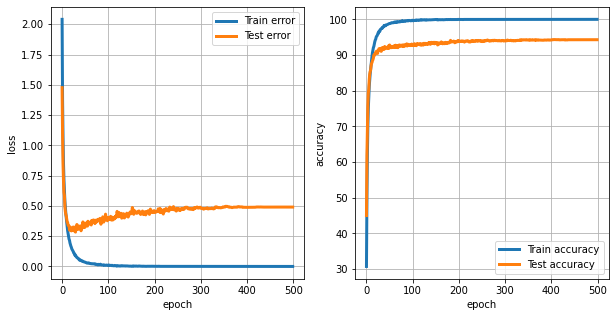

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 94.30181962025317
